In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from scipy.spatial import Delaunay
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from scipy.io import loadmat

from skimage.segmentation import find_boundaries

## Create Numpy file

In [3]:
colormap_data = loadmat('../cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [5]:
path = os.path.abspath('../../../0_Moose_Files/mesh_only/')

model_path = path+'/FeNi.e'
model = netCDF4.Dataset(model_path)

In [6]:
model.variables.keys()

dict_keys(['time_whole', 'eb_status', 'eb_prop1', 'ns_status', 'ns_prop1', 'ss_status', 'ss_prop1', 'coordx', 'coordy', 'eb_names', 'ns_names', 'ss_names', 'coor_names', 'node_num_map', 'connect1', 'connect2', 'elem_num_map', 'elem_ss1', 'side_ss1', 'elem_ss2', 'side_ss2', 'elem_ss3', 'side_ss3', 'elem_ss4', 'side_ss4', 'node_ns1', 'node_ns2', 'node_ns3', 'node_ns4', 'name_nod_var', 'vals_nod_var1', 'vals_nod_var2', 'vals_nod_var3', 'vals_nod_var4', 'vals_nod_var5', 'vals_nod_var6', 'vals_nod_var7', 'vals_nod_var8', 'vals_nod_var9', 'vals_nod_var10', 'vals_nod_var11', 'vals_nod_var12', 'vals_nod_var13', 'name_elem_var', 'vals_elem_var1eb1', 'vals_elem_var2eb1', 'vals_elem_var3eb1', 'vals_elem_var4eb1', 'vals_elem_var5eb1', 'vals_elem_var6eb1', 'vals_elem_var7eb1', 'vals_elem_var8eb1', 'vals_elem_var9eb1', 'vals_elem_var10eb1', 'vals_elem_var11eb1', 'vals_elem_var12eb1', 'vals_elem_var13eb1', 'vals_elem_var14eb1', 'vals_elem_var15eb1', 'vals_elem_var16eb1', 'vals_elem_var17eb1', 'vals_e

In [7]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
var_names = [b"".join(c).decode("latin1") for c in names[:]]
print("Node variables:", var_names)

Node variables: ['bnds', 'c', 'c1', 'c2', 'c3', 'cNi', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'temp', 'w']


In [8]:
def make_array_parallel(nodes, X_all, Y_all, param, blockname="Film", n_jobs=4, nx=500, ny=90,):
    start_time = time.time()
    
    # Convert to regular arrays in case they're masked
    x = np.asarray(X_all[nodes])
    y = np.asarray(Y_all[nodes])
    vals = np.asarray(param[:, nodes])  # shape (nt, nnodes_block)

    # Define structured target grid
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xi, Yi = np.meshgrid(xi, yi)

    nt = vals.shape[0]

    # Precompute Delaunay triangulation for linear interpolation
    tri = Delaunay(np.column_stack((x, y)))

    # Precompute nearest neighbor interpolator (used for NaNs)
    nearest_interp = NearestNDInterpolator(np.column_stack((x, y)), np.zeros_like(x))  # placeholder

    # Function to interpolate a single timestep
    def interp_timestep(t):
        field = vals[t, :]
        linear_interp = LinearNDInterpolator(tri, field)
        Zi = linear_interp(Xi, Yi)
        mask = np.isnan(Zi)
        if np.any(mask):
            Zi[mask] = NearestNDInterpolator(np.column_stack((x, y)), field)(Xi[mask], Yi[mask])
        return Zi

    # Parallel computation over time steps
    arr_list = Parallel(n_jobs=n_jobs)(delayed(interp_timestep)(t) for t in range(nt))
    arr = np.stack(arr_list, axis=2)

    # Flip once after the loop
    arr = np.flip(arr, axis=0)

    end_time = time.time()
    total_time = end_time - start_time

    # print(f"{blockname}: interpolated to shape {arr.shape}")
    print(f"Total time for {blockname}: {total_time:.2f} seconds")

    # return arr, Xi, Yi
    return arr

In [9]:
# comp, LIQ1, FCC2, BCC3, FCC4, BCC5 = [], [], [], [], [], []
parameters = ['vals_nod_var2', 'vals_nod_var7', 'vals_nod_var8', 'vals_nod_var9', 'vals_nod_var10', 'vals_nod_var11', 'vals_nod_var12']

nt, nnodes = model.variables[parameters[0]][:].shape
X_all = model.variables['coordx'][:]
Y_all = model.variables['coordy'][:]
# --- Connectivity: get block-specific nodes ---
connect1 = model.variables["connect1"][:] - 1   # film block
connect2 = model.variables["connect2"][:] - 1   # powder block
nodes_block1 = np.unique(connect1.ravel()).astype(int)
nodes_block2 = np.unique(connect2.ravel()).astype(int)

for i in range(7):
    param = model.variables[parameters[i]][:]
    if i == 0:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        comp=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 1:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        LIQ1=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 2:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC2=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 3:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC3=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 4:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC4=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 5:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC5=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    else:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        temp = np.flip(np.concatenate((powder, film), axis=0), axis=0)

print("Job Done")
model = 1

Total time for Powder: 1.07 seconds
Total time for Film: 1.58 seconds
Total time for Powder: 0.84 seconds
Total time for Film: 1.47 seconds
Total time for Powder: 0.85 seconds
Total time for Film: 1.47 seconds
Total time for Powder: 0.75 seconds
Total time for Film: 1.38 seconds
Total time for Powder: 0.74 seconds
Total time for Film: 1.34 seconds
Total time for Powder: 0.73 seconds
Total time for Film: 1.36 seconds
Total time for Powder: 0.73 seconds
Total time for Film: 1.37 seconds
Job Done


In [13]:
numpy_path = os.path.abspath(f'../../../1_Simulation_Results/numpy_files/schematics/')
np.savez(numpy_path+'/Schematics.npz', arr1=LIQ1, arr2=FCC2, arr3=BCC3, arr4=FCC4, arr5=BCC5)

## Plot schematics

In [3]:
numpy_path = os.path.abspath(f'../../../1_Simulation_Results/numpy_files/schematics/')
numpy_files = np.load(numpy_path + '/Schematics.npz')

LIQ1  = numpy_files['arr1']
FCC2  = numpy_files['arr2']
BCC3  = numpy_files['arr3']
FCC4  = numpy_files['arr4']
BCC5  = numpy_files['arr5']

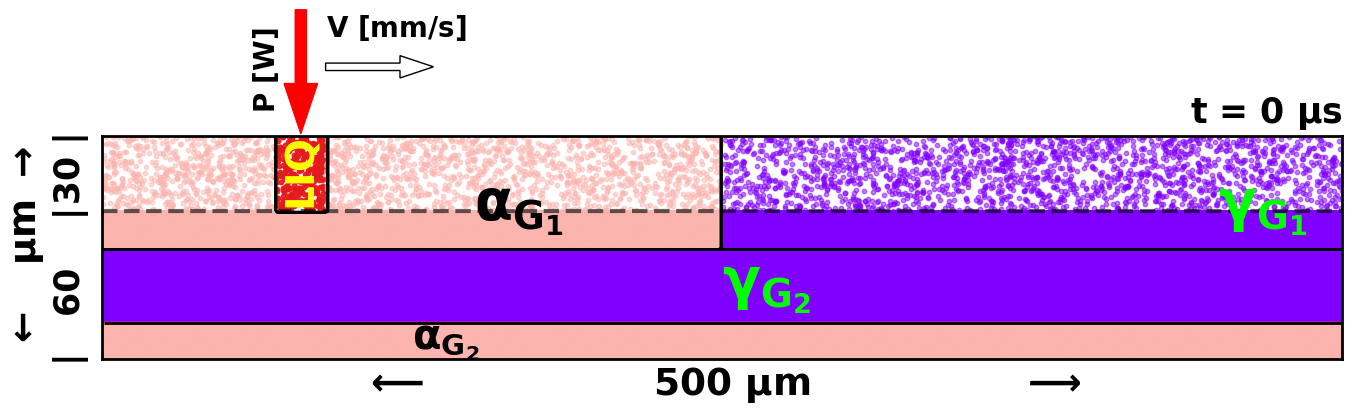

In [59]:
t_step = 0

scan_speed = r'V [$\mathbf{mm/s}$]'
power = r"P [$\mathbf{W}$]"


fig, ax1 = plt.subplots(1,1, figsize=(16,8), frameon=False)
ax1.set_facecolor((0, 0, 0, 0))

cmap =  plt.get_cmap('Set1_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(LIQ1[:120,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.5, vmax=1.0, aspect=1, origin="lower", interpolation='bilinear')

cmap = plt.get_cmap('rainbow_r')
cmap.set_under('white', alpha=0)
hmap2a = ax1.imshow(FCC2[:120,:,t_step], extent=[0, 500, 0, 60], cmap=cmap, vmin=0.5, vmax=1.0, aspect=1, origin="lower", interpolation='bilinear')
cmap = plt.get_cmap('rainbow_r')
cmap.set_under('white', alpha=0)
hmap2b = ax1.imshow(FCC4[:120,:,t_step], extent=[0, 500, 0, 60], cmap=cmap, vmin=0.5, vmax=1.0, aspect=1, origin="lower", interpolation='bilinear')

cmap = plt.get_cmap('Pastel1_r')
cmap.set_under('white', alpha=0) 
hmap3a = ax1.imshow(BCC3[:120,:,t_step], extent=[0, 500, 0, 60], cmap=cmap, vmin=0.5, vmax=1.0, aspect=1, origin="lower", interpolation='bilinear')
cmap = plt.get_cmap('Pastel1_r')
cmap.set_under('white', alpha=0) 
hmap3b = ax1.imshow(BCC5[:120,:,t_step], extent=[0, 500, 0, 60], cmap=cmap, vmin=0.5, vmax=1.0, aspect=1, origin="lower", interpolation='bilinear')

contour_levels = [0.5]
contour = plt.contour(LIQ1[:, :, t_step], extent=[0, 500, 0, 90], levels=contour_levels, colors='k', origin="lower", linewidths=2, linestyles='-')
contour = plt.contour(FCC2[:, :, t_step], extent=[0, 500, 0, 90], levels=contour_levels, colors='k', origin="lower", linewidths=2, linestyles='-')
contour = plt.contour(BCC3[:, :, t_step], extent=[0, 500, 0, 90], levels=contour_levels, colors='k', origin="lower", linewidths=2, linestyles='-')
contour = plt.contour(FCC4[:, :, t_step], extent=[0, 500, 0, 90], levels=contour_levels, colors='k', origin="lower", linewidths=2, linestyles='-')
contour = plt.contour(BCC3[:, :, t_step], extent=[0, 500, 0, 90], levels=contour_levels, colors='k', origin="lower", linewidths=2, linestyles='-')

ax1.arrow(80, 141, 0, -50,  width = 4.5, color='red', length_includes_head=True, clip_on=False)
ax1.text(80-20, 102, power, rotation=90, color='k', fontsize=20, weight='bold')
ax1.set_title(f't = {0:.0f} '+r'$\mathbf{\mu}$s', pad=10, loc='right', fontsize=25, weight='bold')
ax1.text(80+10, 130, s=f'{scan_speed}', fontsize=20, weight = 'bold')
ax1.arrow(80+10, 118, 30, 0,  width = 3, color='k', fill=False, clip_on=False)

ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.spines[:].set_linewidth(2)

LIQ1_txt = ax1.text(73, 63, r'$\mathbf{LIQ}$', rotation=90, fontsize = 28, weight='bold', color='yellow')
FCC2_txt = ax1.text(450, 56, r'$\mathbf{\gamma_{G_1}}$', fontsize = 40, weight='bold', color='lime')
FCC4_txt = ax1.text(250, 25, r'$\mathbf{\gamma_{G_2}}$', fontsize = 40, weight='bold', color='lime')
BCC3_txt = ax1.text(150, 56, r'$\mathbf{\alpha_{G_1}}$', fontsize = 40, weight='bold', color='k')
BCC5_txt = ax1.text(125, 4,  r'$\mathbf{\alpha_{G_2}}$', fontsize = 30, weight='bold', color='k')

ax1.set_xlabel('$\mathbf{\longleftarrow}$                 500 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax1.annotate(r'|   60    |', xy=(0.5, 0.5), xytext=(-0.025, 0.33), rotation=90,
             xycoords='axes fraction', textcoords='axes fraction', fontsize = 25, weight = 'bold', color='k', ha='center', va='center')
ax1.annotate(r'       30 |', xy=(0.5, 0.5), xytext=(-0.025, 0.67), rotation=90,
             xycoords='axes fraction', textcoords='axes fraction', fontsize = 25, weight = 'bold', color='k', ha='center', va='center')
ax1.annotate(r'$\mathbf{\leftarrow}$   $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.06, 0.5), rotation=90,
             xycoords='axes fraction', textcoords='axes fraction', fontsize = 27, weight = 'bold', color='k', ha='center', va='center')

ax1.hlines(y=60, xmin=0, xmax=500, color='k', linestyle='--', linewidth = 3, alpha=0.6)

x1 = np.random.uniform(0,  70, 600)
y1 = np.random.uniform(60, 90, 600)
x2 = np.random.uniform(70, 90, 300)
y2 = np.random.uniform(60, 90, 300)
x3 = np.random.uniform(90, 250, 1240)
y3 = np.random.uniform(60, 90,  1240)
x4 = np.random.uniform(250,500, 1885)
y4 = np.random.uniform(60, 90, 1885)

color1 = plt.get_cmap("Set1_r")(1.0) 
color2 = plt.get_cmap("rainbow_r")(1.0) 
color3 = plt.get_cmap("Pastel1_r")(1.0)
ax1.scatter(x1, y1, s=10, color=color3, alpha=0.5)
ax1.scatter(x2, y2, s=10, color=color1, alpha=0.9)
ax1.scatter(x3, y3, s=10, color=color3, alpha=0.5)
ax1.scatter(x4, y4, s=10, color=color2, alpha=0.5)

# ax1.text(502, 70, s=f'Powder', fontsize=20, weight = 'bold')
# ax1.text(505, 20, s=f'Film', fontsize=20, weight = 'bold', rotation=270)
# ax1.annotate(r'|           |     |', xy=(1.025, 0.5),   rotation=90,
#              xycoords='axes fraction', textcoords='axes fraction', fontsize = 25, weight = 'bold', color='k', ha='center', va='center')

ax1.set_xlim(0, 500)
ax1.set_ylim(0, 90)

# plt.savefig('../../figures/schematics.png',bbox_inches='tight', dpi=200)
# plt.savefig('../../figures/jpg/schematics.jpg',bbox_inches='tight',)

plt.show()
